In [52]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from adjustText import adjust_text
warnings.filterwarnings('ignore')

In [53]:
file_path = 'gnpc_supp.xlsx'
sheet_name = 'SuppTbl5' #differential abundance analysis

# Load the data with row 2 as the header (header=1 is 0-indexed) 
df = pd.read_excel(file_path, sheet_name=sheet_name, header=1)

In [54]:
print(df.shape)
print(df.head())
print(df.dtypes)

(7289, 75)
      SeqId    SomaId                                     TargetFullName  \
0  10000-28  SL019233                                 Beta-crystallin B2   
1   10001-7  SL002564  RAF proto-oncogene serine/threonine-protein ki...   
2  10003-15  SL019245                             Zinc finger protein 41   
3  10006-25  SL019228                ETS domain-containing protein Elk-1   
4  10008-43  SL019234              Guanylyl cyclase-activating protein 1   

  Target UniProt EntrezGeneID EntrezGeneSymbol Organism  \
0  CRBB2  P43320         1415           CRYBB2    Human   
1  c-Raf  P04049         5894             RAF1    Human   
2  ZNF41  P51814         7592            ZNF41    Human   
3   ELK1  P19419         2002             ELK1    Human   
4  GUC1A  P43080         2978           GUCA1A    Human   

   Avg_StdBeta_weighted_AD  Meta_p_weighted_AD  ...  FTD_StdBeta_I   FTD_p_I  \
0                 0.020411            0.105892  ...       0.006329  0.928649   
1                

In [55]:
print(df.columns.tolist())

['SeqId', 'SomaId', 'TargetFullName', 'Target', 'UniProt', 'EntrezGeneID', 'EntrezGeneSymbol', 'Organism', 'Avg_StdBeta_weighted_AD', 'Meta_p_weighted_AD', 'Meta_pval_FDR_AD', 'Meta_pval_Bonf_AD', 'Sig_pos_AD', 'Sig_neg_AD', 'max_sites_AD', 'AD_StdBeta_A', 'AD_p_A', 'AD_StdBeta_C', 'AD_p_C', 'AD_StdBeta_D', 'AD_p_D', 'AD_StdBeta_E', 'AD_p_E', 'AD_StdBeta_F', 'AD_p_F', 'AD_StdBeta_I', 'AD_p_I', 'AD_StdBeta_J', 'AD_p_J', 'AD_StdBeta_L', 'AD_p_L', 'AD_StdBeta_G', 'AD_p_G', 'AD_StdBeta_R', 'AD_p_R', 'Avg_StdBeta_weighted_PD', 'Meta_p_weighted_PD', 'Meta_pval_FDR_PD', 'Meta_pval_Bonf_PD', 'Sig_pos_PD', 'Sig_neg_PD', 'max_sites_PD', 'PD_StdBeta_C', 'PD_p_C', 'PD_StdBeta_F', 'PD_p_F', 'PD_StdBeta_J', 'PD_p_J', 'PD_StdBeta_L', 'PD_p_L', 'PD_StdBeta_Q', 'PD_p_Q', 'PD_StdBeta_R', 'PD_p_R', 'PD_StdBeta_T', 'PD_p_T', 'Avg_StdBeta_weighted_FTD', 'Meta_p_weighted_FTD', 'Meta_pval_FDR_FTD', 'Meta_pval_Bonf_FTD', 'Sig_pos_FTD', 'Sig_neg_FTD', 'max_sites_FTD', 'FTD_StdBeta_C', 'FTD_p_C', 'FTD_StdBeta_I

In [56]:
# Prepare data for volcano plots
volcano_data = df.copy()
volcano_data['neg_log10_pval_AD'] = -np.log10(volcano_data['Meta_p_weighted_AD'])
volcano_data['cohort_consistency_AD'] = volcano_data['Sig_pos_AD'] + volcano_data['Sig_neg_AD']

print(volcano_data[['Avg_StdBeta_weighted_AD', 'neg_log10_pval_AD', 'Sig_pos_AD', 'Sig_neg_AD', 'cohort_consistency_AD']].head(10))

   Avg_StdBeta_weighted_AD  neg_log10_pval_AD  Sig_pos_AD  Sig_neg_AD  \
0                 0.020411           0.975136           0           0   
1                -0.018095           0.063914           1           4   
2                 0.049706           3.112235           2           0   
3                 0.028990           2.556576           1           0   
4                -0.014837           0.820047           2           1   
5                 0.030080           1.457310           3           0   
6                -0.000224           0.420371           3           0   
7                -0.092931          18.187980           3           3   
8                 0.032006           1.487738           1           0   
9                 0.009330           1.038257           2           3   

   cohort_consistency_AD  
0                      0  
1                      5  
2                      2  
3                      1  
4                      3  
5                      3  
6      

In [57]:
# Create 'is_top' column based on FDR significance in any disease
volcano_data['is_top'] = (
    (volcano_data['Meta_pval_FDR_AD'] < 0.05) |
    (volcano_data['Meta_pval_FDR_PD'] < 0.05) |
    (volcano_data['Meta_pval_FDR_FTD'] < 0.05) |
    (volcano_data['p_ALS_fdr'] < 0.05)
)

sig_proteins_all = volcano_data[volcano_data['is_top']]

print(f"Total significant proteins: {len(sig_proteins_all)}")
print(f"\nSignificant in each disease:")
print(f"AD: {(volcano_data['Meta_pval_FDR_AD'] < 0.05).sum()}")
print(f"PD: {(volcano_data['Meta_pval_FDR_PD'] < 0.05).sum()}")
print(f"FTD: {(volcano_data['Meta_pval_FDR_FTD'] < 0.05).sum()}")
print(f"ALS: {(volcano_data['p_ALS_fdr'] < 0.05).sum()}")

Total significant proteins: 6214

Significant in each disease:
AD: 4754
PD: 4678
FTD: 71
ALS: 82


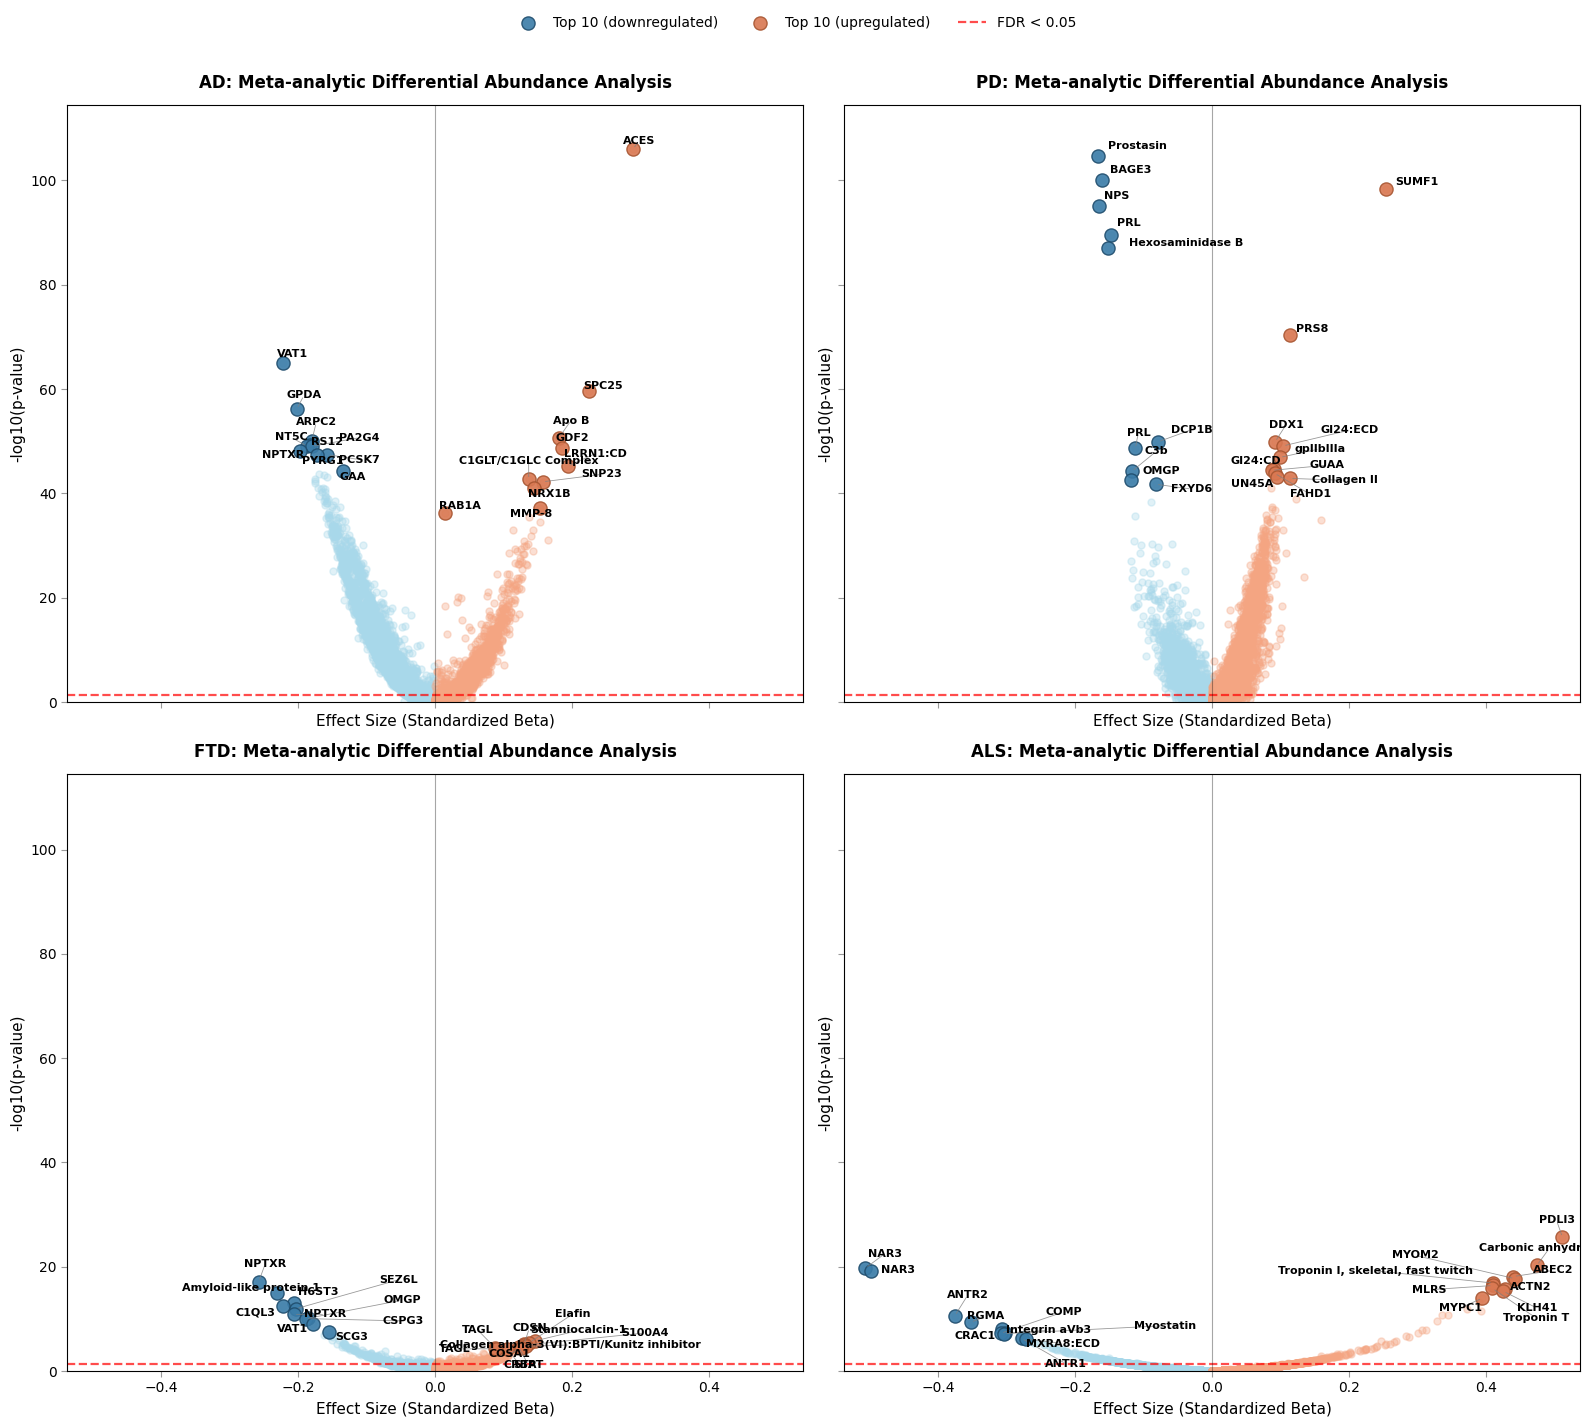

In [58]:
from adjustText import adjust_text
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Panels: (name, beta_col, pval_col)
diseases = [
    ('AD',  'Avg_StdBeta_weighted_AD',  'Meta_p_weighted_AD'),
    ('PD',  'Avg_StdBeta_weighted_PD',  'Meta_p_weighted_PD'),
    ('FTD', 'Avg_StdBeta_weighted_FTD', 'Meta_p_weighted_FTD'),
    ('ALS', 'StdBeta_ALS',              'p_ALS')
]

TOP_K = 10  # >>> only top 10 each direction

# scale
all_betas, all_neglogp = [], []
for _, bcol, pcol in diseases:
    b = volcano_data[bcol].dropna()
    p = np.clip(volcano_data[pcol].dropna(), 1e-300, None)
    all_betas.append(b)
    all_neglogp.append(-np.log10(p))

max_abs_beta = np.max(np.abs(pd.concat(all_betas)))
x_pad = 0.05 * max_abs_beta
xlim = (-max_abs_beta - x_pad, max_abs_beta + x_pad)

ymax = pd.concat(all_neglogp).max()
ylim = (0, ymax * 1.08)

fig, axes = plt.subplots(2, 2, figsize=(16, 14), sharex=True, sharey=True)
axes = axes.flatten()

# palette
c_light_down, c_light_up = '#A8D8EA', '#F4A582'
c_dark_down,  c_dark_up  = '#3B7CA8', '#D97852'
c_edge_down,  c_edge_up  = '#1F4D6D', '#A85632'
fdr_threshold = -np.log10(0.05)

for idx, (name, bcol, pcol) in enumerate(diseases):
    ax = axes[idx]

    # base data
    betas = volcano_data[bcol]
    pvals = np.clip(volcano_data[pcol], 1e-300, None)
    neglogp = -np.log10(pvals)

    down = volcano_data[betas < 0]
    up   = volcano_data[betas > 0]

    # background points
    ax.scatter(down[bcol], -np.log10(np.clip(down[pcol], 1e-300, None)),
               s=26, alpha=0.35, c=c_light_down, rasterized=True)
    ax.scatter(up[bcol],   -np.log10(np.clip(up[pcol],   1e-300, None)),
               s=26, alpha=0.35, c=c_light_up,   rasterized=True)

    # top-k by p-value within each side 
    top_down = volcano_data[(volcano_data['is_top']) & (volcano_data[bcol] < 0)].nsmallest(TOP_K, pcol)
    top_up   = volcano_data[(volcano_data['is_top']) & (volcano_data[bcol] > 0)].nsmallest(TOP_K, pcol)
    top_sel  = pd.concat([top_down, top_up], ignore_index=True)

    ax.scatter(top_down[bcol], -np.log10(np.clip(top_down[pcol], 1e-300, None)),
               s=90, alpha=0.9, c=c_dark_down, edgecolors=c_edge_down, linewidth=1.0,
               label=f'Top {TOP_K} (downregulated)', zorder=3)
    ax.scatter(top_up[bcol],   -np.log10(np.clip(top_up[pcol],   1e-300, None)),
               s=90, alpha=0.9, c=c_dark_up,   edgecolors=c_edge_up,   linewidth=1.0,
               label=f'Top {TOP_K} (upregulated)',   zorder=3)

    # labels
    texts = []
    for _, row in top_sel.iterrows():
        texts.append(
            ax.text(row[bcol], -np.log10(max(row[pcol], 1e-300)),
                    row['Target'], fontsize=8, fontweight='bold',
                    zorder=4, clip_on=True)
        )

    adjust_text(
        texts, ax=ax,
        arrowprops=dict(arrowstyle='-', color='gray', lw=0.6, alpha=0.8),
        expand_points=(1.2, 1.4), expand_text=(1.2, 1.4),
        force_points=0.2, force_text=0.2, lim=100,
        only_move={'points': 'y', 'text': 'xy'}
    )

    # guides & frame
    ax.axhline(fdr_threshold, color='red', linestyle='--', linewidth=1.6, alpha=0.7, label='FDR < 0.05')
    ax.axvline(0, color='black', linestyle='-', linewidth=0.8, alpha=0.35)

    ax.tick_params(axis='both', which='both', length=4, color='#999', labelsize=10)

    ax.set_title(f'{name}: Meta-analytic Differential Abundance Analysis',
                 fontsize=12, fontweight='bold', pad=12)
    ax.set_xlabel('Effect Size (Standardized Beta)', fontsize=11)
    ax.set_ylabel('-log10(p-value)', fontsize=11)

    # shared limits
    ax.set_xlim(xlim); ax.set_ylim(ylim)

# shared legend outside so it never collides
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles[:3], labels[:3], loc='upper center', bbox_to_anchor=(0.5, 1.02),
           ncol=3, frameon=False, fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()
